In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import warnings 
warnings.filterwarnings('ignore') # ignoring warnings

In [3]:
train_data_directory='/kaggle/input/chest-xray-covid19-pneumonia/Data/train'
test_data_directory='/kaggle/input/chest-xray-covid19-pneumonia/Data/test'

def images_to_df (data_directory):
    #Initialize empty dataframe with columns 'directory' and 'class'
    data_df = pd.DataFrame(columns=['directory', 'class'])
    #Loop through all the files in the directory
    for filename in os.listdir(data_directory):
        # Loop through all the images in the subdirectory
        for img in os.listdir(data_directory+"/"+filename):
            # Append the image's path and its class to the dataframe
            data_df = data_df.append({'directory':data_directory+"/"+filename+"/"+img, 'class':filename},ignore_index = True)
    return data_df


train_data_df= images_to_df(train_data_directory)
test_data_df= images_to_df(test_data_directory)

In [6]:
# Definig parameters 
batch_size = 24
size = (224,224,3)
img_width = img_hight = size[0]

classes =['COVID19', 'NORMAL', 'PNEUMONIA']

In [7]:
# Creating a data generator with rescaling of pixel values by dividing 255 
#and splitting validation set with 20% of data
datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

# Generate shuffled training data
train_data = datagen.flow_from_dataframe(train_data_df, x_col='directory', y_col='class',
                                        image_size=(img_hight, img_width), target_size=(img_hight, img_hight),
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical', 
                                        classes=classes, subset='training',seed=42)

# Generate shuffled validation data
val_data = datagen.flow_from_dataframe(train_data_df, x_col='directory', y_col='class',
                                       image_size=(img_hight, img_width), target_size=(img_hight, img_hight), 
                                       color_mode='rgb',batch_size=batch_size, class_mode='categorical',
                                       classes=classes, subset='validation',seed=42)

# Testing data
test_data = datagen.flow_from_dataframe(test_data_df, x_col='directory', y_col='class',
                                            image_size=(img_hight, img_width), target_size=(img_hight, img_hight), color_mode='rgb',
                                            batch_size=batch_size, class_mode='categorical',classes=classes, 
                                            subset=None,seed=42)

unshuffled_test_data = datagen.flow_from_dataframe(test_data_df, x_col='directory', y_col='class',
                                            image_size=(img_hight, img_width), target_size=(img_hight, img_hight), color_mode='rgb',
                                            batch_size=batch_size, class_mode='categorical',classes=classes, 
                                            subset=None,shuffle=False)


Found 4116 validated image filenames belonging to 3 classes.
Found 1028 validated image filenames belonging to 3 classes.
Found 1288 validated image filenames belonging to 3 classes.
Found 1288 validated image filenames belonging to 3 classes.


In [8]:
# Define the deep learning model
regularizer=keras.regularizers.l2(0.0001)
model = Sequential()

# Add the first four convolutional layers
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3),padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))

# Add the fifth max pooling layer

model.add(MaxPooling2D(pool_size=(5, 5),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Add the next four convolutional layers
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu',padding='same', kernel_regularizer=regularizer))

# Add the tenth max pooling layer

model.add(MaxPooling2D(pool_size=(5, 5),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#Flatten the data for fully connected layers
model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

#output layer
model.add(Dense(3, activation='softmax'))

2023-02-20 15:03:48.330004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 15:03:48.433708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 15:03:48.434597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 15:03:48.436068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
!pip install gdown
import gdown

#* Download the model weights and history
url = "https://drive.google.com/file/d/1afV5f3RXOFNF3oOQtSn3vleDpxWXVyuY/view?usp=share_link"
output = "model.h5"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

url = "https://drive.google.com/file/d/13JmS6kSv34p1EhZ5S6O4ZY7BVo1r-qlY/view?usp=share_link"
output = "Model_history.csv"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1afV5f3RXOFNF3oOQtSn3vleDpxWXVyuY
To: /kaggle/working/model.h5
100%|██████████| 30.4M/30.4M [00:00<00:00, 38.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=13JmS6kSv34p1EhZ5S6O4ZY7BVo1r-qlY
To: /kaggle/working/Model_history.csv
100%|██████████| 4.35k/4.35k [00:00<00:00, 10.2MB/s]


'Model_history.csv'

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights('model.h5')

In [11]:
History = pd.read_csv('/kaggle/working/Model_history.csv')
History.insert(0, 'epochs', range(1,len(History)+1))
History.head()

,epochs,loss,accuracy,val_loss,val_accuracy,lr
0,1,0.808516,0.697279,0.841145,0.770428,0.001
1,2,0.506339,0.837949,1.165131,0.723735,0.001
2,3,0.411693,0.878523,0.481166,0.828794,0.001
3,4,0.361023,0.901846,1.165983,0.735409,0.001
4,5,0.325205,0.914237,0.522765,0.830739,0.001


In [37]:
print("Training_accuracy", History['accuracy'].iloc[-1])
print("Validation_accuracy", History['val_accuracy'].iloc[-1])

Training_accuracy 0.9914966225624084
Validation_accuracy 0.9678988456726074


In [12]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


def Plot_history(
    history,
    theme = 'plotly',
    Plot_mode="dice_coef",
    y_range_loss_range=1,
    SHOW_GRID=False,
    title=None,
    autorange = True,
):
    trace1_col = Plot_mode
    trace2_col = "val_" + Plot_mode
    history = pd.DataFrame((history.copy()))
    if history.columns[0] != "epoch":
        history[history.columns[0]] = history[history.columns[0]].apply(lambda x: x + 1)
        history.rename(columns={history.columns[0]: "epoch"}, inplace=True)

    if y_range_loss_range == None:
        y_range_max_range = max(history[trace1_col].max(), history[trace2_col].max())
    else:
        y_range_max_range = y_range_loss_range
    history[trace1_col] = history[trace1_col].apply(lambda x: round(x, 4))
    history[trace2_col] = history[trace2_col].apply(lambda x: round(x, 4))

    trace1 = go.Scatter(
        x=history[history.columns[0]], y=history[trace1_col], name="train_" + trace1_col,hovertemplate=None)
    trace2 = go.Scatter(
        x=history[history.columns[0]], y=history[trace2_col], name=trace2_col, hovertemplate=None
    )
    fig = go.Figure(
        data=[trace1, trace2],
        layout=go.Layout(
            xaxis=dict(
                range=[1, history[history.columns[0]].max()],
                autorange=False,
            ),
            yaxis=dict(range=[0, y_range_max_range], autorange=True),
            showlegend=True,
            hovermode="x unified",
        ),
    )


    fig.update_layout(
        title=Plot_mode + f" after {len(history)} epochs",
        xaxis_title="Epochs",
        yaxis_title=Plot_mode,
        title_x=0.5,
        autosize= True,
    )
    
    fig.update_xaxes(tickfont=dict(size=10))
    fig.update_layout(xaxis=dict(tickmode="linear", tick0=0, dtick=int(len(history)/10)))
    fig.update_layout(yaxis=dict(tickmode="linear", tick0=0, dtick=round(max(history[Plot_mode]/5),1)))
    if autorange == True:
        fig.update_layout(yaxis= dict(autorange = True))
    fig.update_layout(xaxis=dict(showgrid=SHOW_GRID), yaxis=dict(showgrid=SHOW_GRID))
    fig.update_layout(template=theme)
    
    fig.show()

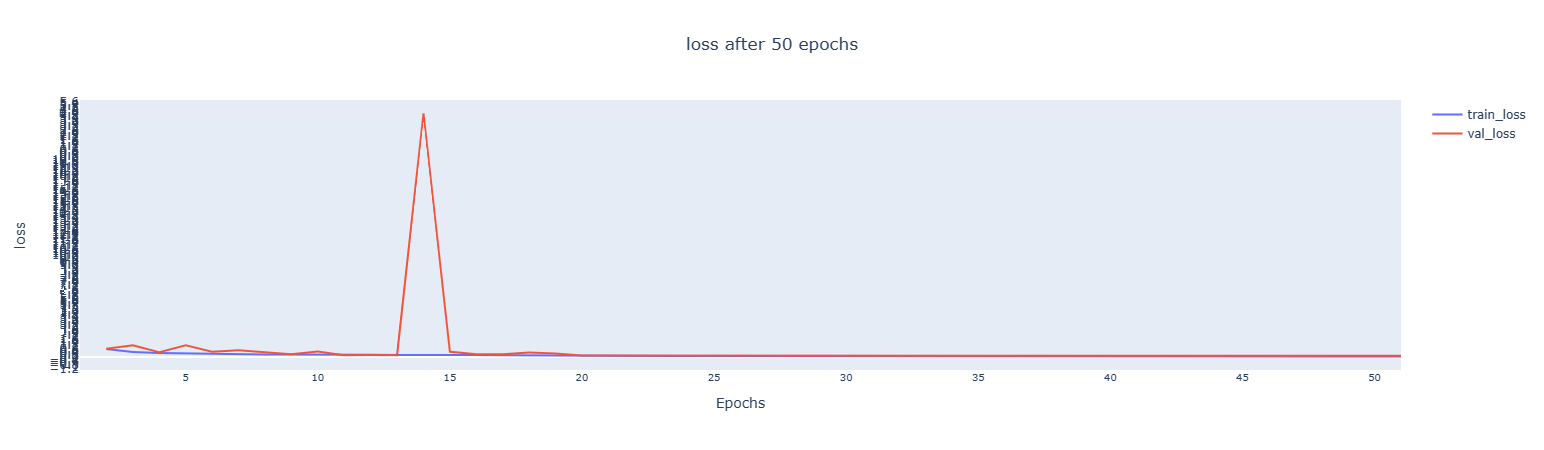

In [13]:
Plot_history(History,Plot_mode='loss')

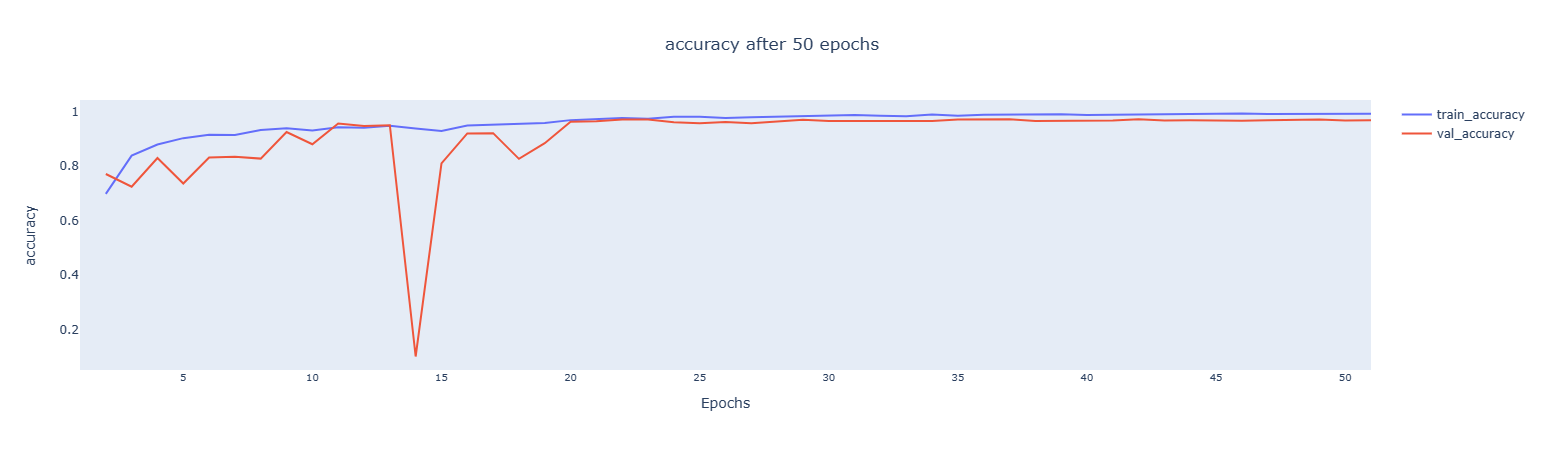

In [14]:
Plot_history(History,Plot_mode='accuracy')

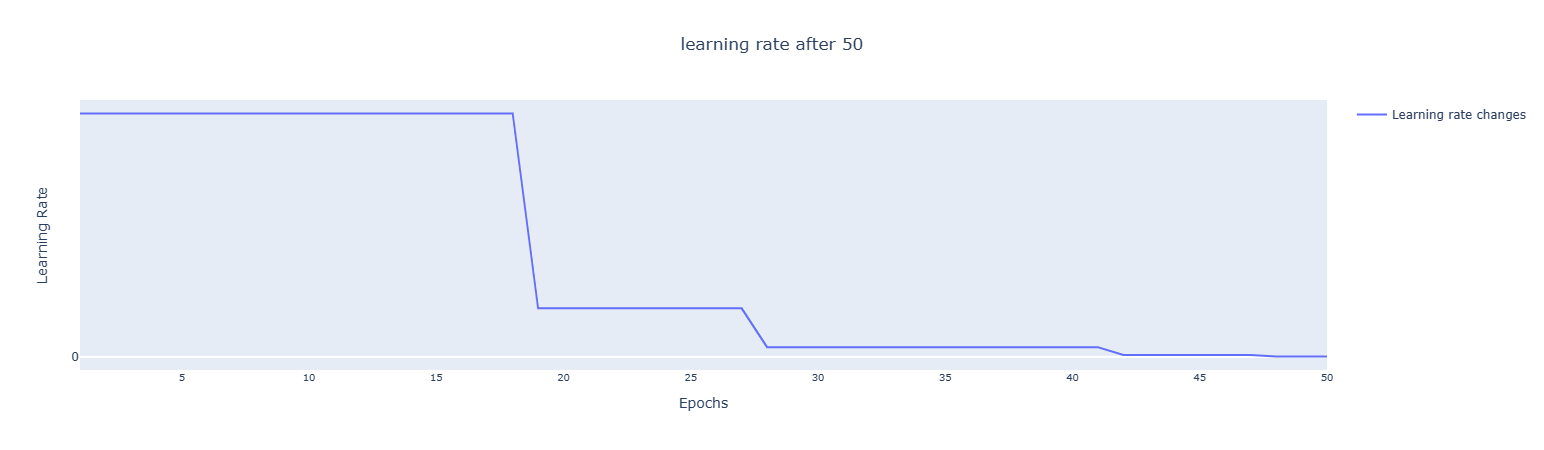

In [15]:
history = History.copy()
Plot_mode = "lr"
trace1 = go.Scatter(
        x=history[history.columns[0]], y=history['lr'], name="Learning rate changes" ,hovertemplate=None
    )
fig = go.Figure(
        data=[trace1],
        layout=go.Layout(
            xaxis=dict(
                range=[1, history[history.columns[0]].max()],
                autorange=False,
            ),
            yaxis=dict(range=[0, max(history['lr'])], autorange=False),
            showlegend=True,
            hovermode="x unified",
        ),
    )
fig.update_layout(
    title="learning rate" + f" after {len(history)}",
    xaxis_title="Epochs",
    yaxis_title='Learning Rate',
    title_x=0.5,
)

fig.update_xaxes(tickfont=dict(size=10))
fig.update_layout(xaxis=dict(tickmode="linear", tick0=0, dtick=int(len(history)/10)))
fig.update_layout(yaxis=dict(tickmode="linear", tick0=0, dtick=round(max(history[Plot_mode]/5),1)))

fig.update_layout(yaxis= dict(autorange = True))
fig.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
fig.update_layout(template='plotly')

fig.show()

In [16]:
history = pd.read_csv('Model_history.csv')
history.insert(0, 'epochs', range(1,len(history)+1))
history.head()

,epochs,loss,accuracy,val_loss,val_accuracy,lr
0,1,0.808516,0.697279,0.841145,0.770428,0.001
1,2,0.506339,0.837949,1.165131,0.723735,0.001
2,3,0.411693,0.878523,0.481166,0.828794,0.001
3,4,0.361023,0.901846,1.165983,0.735409,0.001
4,5,0.325205,0.914237,0.522765,0.830739,0.001


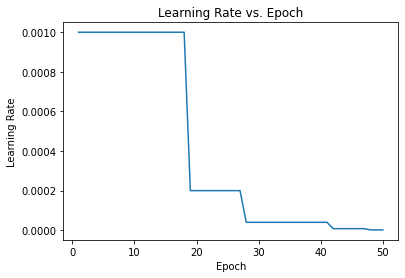

In [17]:
# Plot the learning rate curve
plt.plot(history.epochs , history.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Epoch')
plt.show()

<AxesSubplot:>

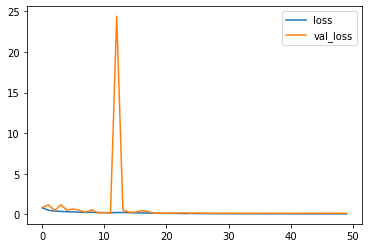

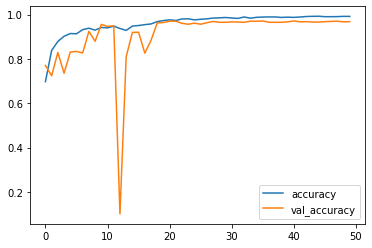

In [33]:
history[['loss','val_loss']].plot() 
history[['accuracy','val_accuracy']].plot() 

In [19]:
model.evaluate(val_data)

2023-02-20 15:04:11.765619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-20 15:04:13.926707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 31s 542ms/step - loss: 0.0399 - accuracy: 0.9981


[0.03986543044447899, 0.9980545043945312]

In [20]:
model.evaluate(test_data)

54/54 [==============================] - 44s 814ms/step - loss: 0.1487 - accuracy: 0.9689


[0.14868181943893433, 0.9689440727233887]

In [21]:
model.evaluate(unshuffled_test_data)

54/54 [==============================] - 29s 538ms/step - loss: 0.1487 - accuracy: 0.9689


[0.14868178963661194, 0.9689440727233887]

In [22]:
predictions = model.predict(unshuffled_test_data, verbose=1 ,workers=5, use_multiprocessing=True)
predictions.shape

54/54 [==============================] - 24s 415ms/step


(1288, 3)

In [23]:
class_dict = test_data.class_indices
class_dict = {value: key for key, value in class_dict.items()} 
predicted_classes = [class_dict.get(list(predictions[i]).index(predictions[i].max())) for i in range(len(predictions))]
test_data_df['predicted_class'] = predicted_classes
test_data_df['matched'] = (test_data_df['class'] == test_data_df['predicted_class'])
test_data_df.sample(15)

,directory,class,predicted_class,matched
731,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
572,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
197,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
283,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
646,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
181,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
324,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
301,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
143,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True
714,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,PNEUMONIA,True


In [24]:
print("Correct prediction: " ,len(test_data_df[test_data_df['matched' ]== True]))
print("False prediction: " ,len(test_data_df[test_data_df['matched' ]== False]))
print("Accucary of the model on unseen data " , round(len(test_data_df[test_data_df['matched' ]== True])/len(test_data_df),4), "%")

Correct prediction:  1248
False prediction:  40
Accucary of the model on unseen data  0.9689 %


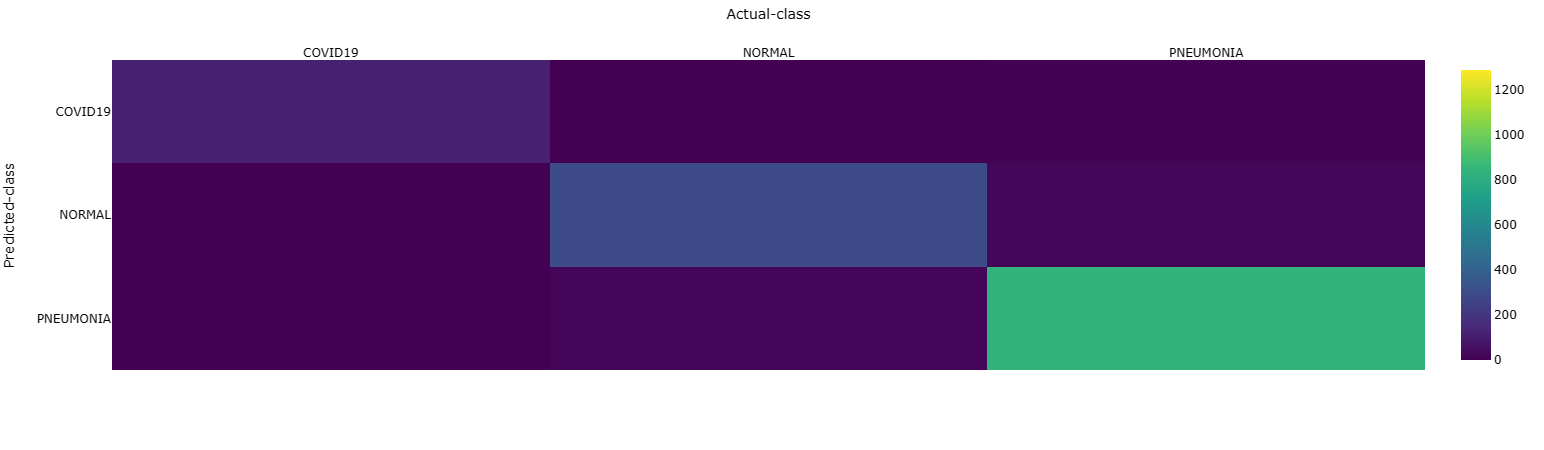

In [40]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
conf_mat = confusion_matrix(test_data_df['class'], 
                            test_data_df['predicted_class'],
                            labels = list(class_dict.values()))

def confusion_matrix_plot(conf_mat,labels = list(class_dict.values()),length = len(test_data_df)):
    fig = px.imshow(conf_mat,
                    labels=dict(x="Actual-class", y="Predicted-class"), color_continuous_scale='viridis',
                    x=labels,
                    y=labels,
                    text_auto=True, aspect="auto", range_color = [0,length]
                   )
    fig.update_xaxes(side="top")
    fig.update_layout(font=dict(color='black'))
    fig.show()

confusion_matrix_plot(conf_mat,labels = list(class_dict.values()),length = len(test_data_df))
#! when saving plot version it doesn't show any text--> kaggle backend problem

In [26]:
y_pred = model.predict(unshuffled_test_data)
predictions1 = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=unshuffled_test_data.classes

In [27]:
p = precision_score(y_true, predictions1, average = 'macro')
r = recall_score(y_true, predictions1, average = 'macro')
f = f1_score(y_true, predictions1, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

precision:  0.969408275989974
recall:  0.9632224196349074
F1 score:  0.9662561591259706


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

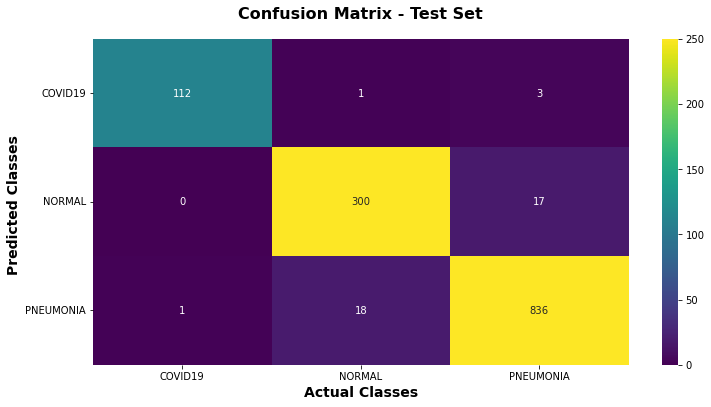

In [44]:
ConfusionMatrix = pd.DataFrame(confusion_matrix(y_true, predictions1), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(ConfusionMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'viridis')
ax.set_xlabel('Actual Classes',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0)

ax.set_ylabel('Predicted Classes ',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0)
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [29]:
print(classification_report(y_true, predictions1))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       116
           1       0.94      0.95      0.94       317
           2       0.98      0.98      0.98       855

    accuracy                           0.97      1288
   macro avg       0.97      0.96      0.97      1288
weighted avg       0.97      0.97      0.97      1288



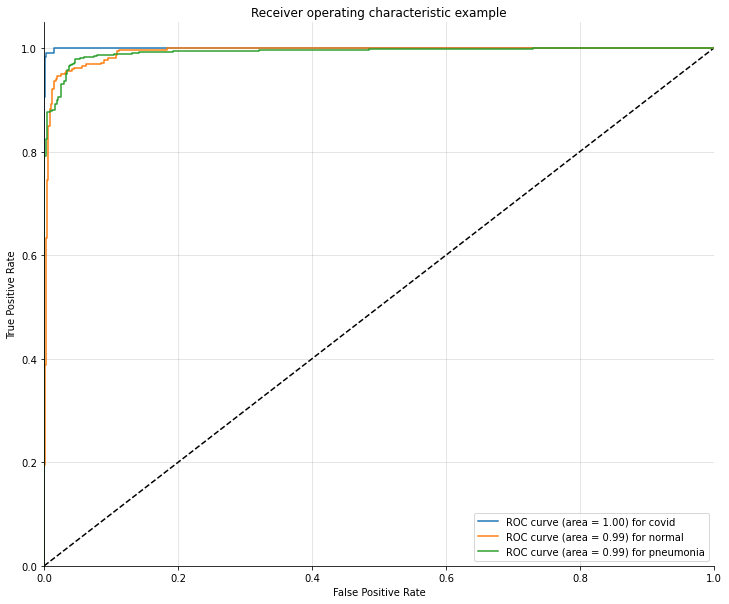

In [45]:
# ROC curve

class_to_label_map = {0 : 'covid', 1 : 'normal', 2 : 'pneumonia'}

def plot_multiclass_roc(y_test, y_score, n_classes, figsize):                   
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


plot_multiclass_roc(unshuffled_test_data.labels, y_pred, n_classes=3, figsize= (12,10 ) )